# 네이버 영화평 감성분석

### 한글 폰트 사용

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
# 설치 뒤 font-manager rebuild
import matplotlib.font_manager as fm
fm._rebuild()

In [3]:
import matplotlib.pyplot as plt
plt.rc('font',family='NanumGothic')

### Konlpy 설치

In [4]:
!pip install Konlpy

     |████████████████████████████████| 19.4MB 7.9MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
     |████████████████████████████████| 450kB 46.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [5]:
import konlpy
konlpy.__version__

'0.5.2'

## 파일 업로드

In [6]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_test.csv to naver_movie_test.csv


In [7]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_train.csv to naver_movie_train.csv


In [8]:
import pandas as pd

train_df = pd.read_csv('naver_movie_train.csv',sep='\t')
test_df = pd.read_csv('naver_movie_test.csv',sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### 한글 형태소 분석

In [9]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [10]:
# 토큰화와 불용어 제거 
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅎㅎ','ㅠㅠ']
okt = Okt()

In [11]:
X_train = []
for sentence in tn.tqdm(train_df.document):
    morphs = okt.morphs(sentence,stem=True)
    temp_X = ' '.join([word for word in morphs if not word in stopwords])
    X_train.append(temp_X)

In [12]:
X_test = []
for sentence in tn.tqdm(test_df.document):
    morphs = okt.morphs(sentence,stem=True)
    temp_X = ' '.join([word for word in morphs if not word in stopwords])
    X_test.append(temp_X)

In [13]:
X_train[:3]

['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다']

### 케라스로 인코딩

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
# 상위 3만개의 단어로 인코딩
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train[:3]

[[48, 450, 15, 256, 655],
 [929, 453, 40, 598, 1, 210, 1445, 23, 957, 671, 18],
 [382, 2440, 25011, 2311, 5667, 2, 218, 8]]

In [18]:
# 전체 데이터의 길이 분포
print('최대 길이 : ', max(len(l) for l in X_train))
print('평균 길이 : ', sum(map(len,X_train)) / len(X_train))

최대 길이 :  69
평균 길이 :  10.660699220116468


In [19]:
# 샘플의 길이를 30으로 셋팅
max_len = 30
X_train = pad_sequences(X_train,maxlen=max_len)
X_test = pad_sequences(X_test,maxlen = max_len)
y_train = train_df.label.values
y_test = test_df.label.values

#  1. LSTM 모델 정의, 설정, 학습 평가

In [20]:
model = Sequential([
                    Embedding(max_words,100),
                    LSTM(128),
                    Dense(1,activation="sigmoid")
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,117,377
Trainable params: 3,117,377
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
mc = ModelCheckpoint('naver_lstm_best.h5',save_best_only=True)

In [24]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 69s 31ms/step - loss: 0.3886 - accuracy: 0.8226 - val_loss: 0.3514 - val_accuracy: 0.8466
Epoch 2/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.2918 - accuracy: 0.8756 - val_loss: 0.3429 - val_accuracy: 0.8505
Epoch 3/4
1944/1944 [==============================] - 58s 30ms/step - loss: 0.2355 - accuracy: 0.9023 - val_loss: 0.3792 - val_accuracy: 0.8487
Epoch 4/4
1944/1944 [==============================] - 58s 30ms/step - loss: 0.1888 - accuracy: 0.9233 - val_loss: 0.4156 - val_accuracy: 0.8451


In [28]:
best_model = load_model('naver_lstm_best.h5')
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3496 - accuracy: 0.8476


[0.34964755177497864, 0.8475762605667114]

### 학습과정 시각화

In [25]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len= np.arange(1,len(y_acc) + 1)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


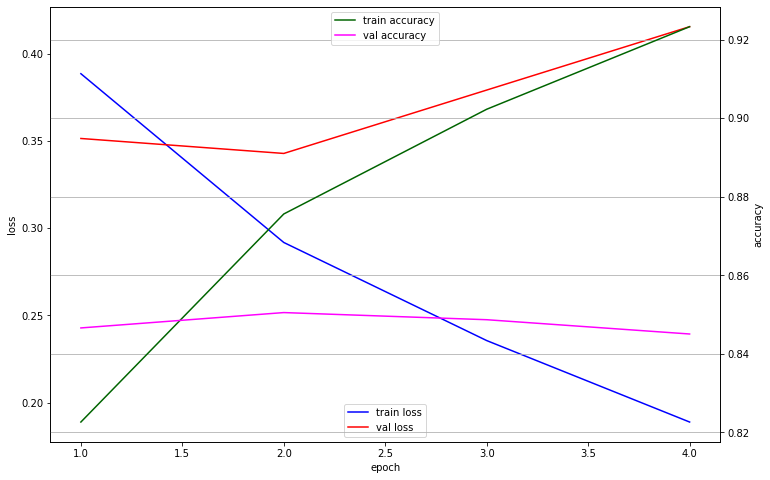

In [26]:
fig, ax0 = plt.subplots(figsize = (12,8))
ax1 = ax0.twinx()           # x축을 공유할 것이다 

ax0.plot(x_len, y_loss, c = 'blue', label ='train loss')
ax0.plot(x_len, y_vloss, c='red', label = 'val loss')
ax0.set_ylabel('loss')

ax1.plot(x_len, y_acc, c = 'darkgreen', label ='train accuracy')
ax1.plot(x_len, y_vacc, c='magenta', label = 'val accuracy')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')

ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.grid()
plt.show()

# 2. GRU Model

In [29]:
from tensorflow.keras.layers import GRU

In [30]:
model2 = Sequential([
                    Embedding(max_words,100),
                    GRU(128),
                    Dense(1,activation="sigmoid")
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,088,449
Trainable params: 3,088,449
Non-trainable params: 0
_________________________________________________________________


In [31]:
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
mc = ModelCheckpoint('naver_gru_best.h5',save_best_only=True)

In [33]:
history2 = model2.fit(X_train, y_train, validation_split=0.2, batch_size=60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 61s 30ms/step - loss: 0.3839 - accuracy: 0.8244 - val_loss: 0.3431 - val_accuracy: 0.8500
Epoch 2/4
1944/1944 [==============================] - 59s 30ms/step - loss: 0.2847 - accuracy: 0.8798 - val_loss: 0.3404 - val_accuracy: 0.8503
Epoch 3/4
1944/1944 [==============================] - 59s 31ms/step - loss: 0.2275 - accuracy: 0.9070 - val_loss: 0.3781 - val_accuracy: 0.8474
Epoch 4/4
1944/1944 [==============================] - 59s 30ms/step - loss: 0.1799 - accuracy: 0.9285 - val_loss: 0.4418 - val_accuracy: 0.8437


In [34]:
best_model2 = load_model('naver_gru_best.h5')
best_model2.evaluate(X_test, y_test)

1532/1532 [==============================] - 6s 3ms/step - loss: 0.3463 - accuracy: 0.8480


[0.34626367688179016, 0.8479844927787781]

# 3. Conv1d + GRU

In [35]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

In [40]:
model3 = Sequential([
    Embedding(max_words,100),
    Dropout(0.5),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    GRU(60),
    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60)                22680     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 3,054,805
Trainable params: 3,054,805
Non-trainable params: 0
____________________________________________

In [41]:
model3.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',metrics=['accuracy']
)

mc = ModelCheckpoint('naver_conv1d_gru_best.h5',save_best_only=True)

In [42]:
history3 = model3.fit(X_train, y_train, validation_split=0.2, batch_size=60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 85s 29ms/step - loss: 0.4926 - accuracy: 0.7443 - val_loss: 0.4481 - val_accuracy: 0.7762
Epoch 2/4
1944/1944 [==============================] - 56s 29ms/step - loss: 0.4115 - accuracy: 0.8002 - val_loss: 0.4433 - val_accuracy: 0.7798
Epoch 3/4
1944/1944 [==============================] - 56s 29ms/step - loss: 0.3619 - accuracy: 0.8263 - val_loss: 0.4648 - val_accuracy: 0.7761
Epoch 4/4
1944/1944 [==============================] - 55s 28ms/step - loss: 0.3236 - accuracy: 0.8445 - val_loss: 0.4960 - val_accuracy: 0.7756


In [43]:
best_model3 = load_model('naver_conv1d_gru_best.h5')
best_model3.evaluate(X_test, y_test)

1532/1532 [==============================] - 4s 2ms/step - loss: 0.4517 - accuracy: 0.7760


[0.45173388719558716, 0.7759975790977478]